In [ ]:
"""Programme forward pour modéliser les temps d'arrivée de la réflexion sur le bulbe lors d'une injection de type Porchet
suivie par radar de sol"""

%matplotlib inline

import numpy as np
import os
#import matplotlib.pyplot as plt
#import sys, h5py, binascii

import pygimli as pg
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes, mesh
from pygimli.mplviewer import drawMesh
from pygimli.viewer import showMesh

from definition_maillage import *
from ecriture_fich_gprMax import *
from ecriture_in import *
from interp_charge_trou import *
from interp_maillage_gprMax import *

#Def des paramètres de géométrie du modéle
xmin,xmax = 0, 40 # en cm
emin,emax = 0, 80 #  elevation en cm
dtrou = 30 # prof du trou en cm
etrou = emax - dtrou # elevation du fond du trou
r=2 # rayon du trou en cm
dx = .1 #On définit le pas de la maille
zaff= 20 #profondeur en cm jusqu'où on souhaite un maillage affiné. 
eaff=etrou-zaff

h_0=-5.49E10 #-80 #charge initiale en cm, soit l'état initial du sol (teneur en eau exprimée en charge)
h_1=10 #10 #hauteur d'eau au fond du trou en cm

#Définition du maillage triangulaire
[mesh, pg_pos, mesh_pos, mesh_cells]=definition_maillage(xmin, xmax, emin, emax, dtrou, etrou, r, dx, zaff, eaff)

#Début de la boucle de calcul
for i in range(0,1):
    tr = 0.098 #0.06
    ts = 0.459 #0.3
    alpha = 0.015 #0.016
    n = 1.2531 #8.52
    Ks = 0.0102 #0.07
    param = [tr, ts, tr, ts, alpha, n, Ks, Ks, ts] #Paramètres d'entrée tr, ts, alpha, n, Ks
    temps=[0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 1.17, 1.33, 1.50, 1.67, 1.83, 2.00, 2.17, 2.33, 2.50, 2.67, 2.83, 3.00, 3.17, 3.33, 3.50, 3.67, 3.83, 4.00, 4.17, 4.33, 4.50, 4.67, 4.83, 5.00, 5.17, 5.33, 5.50, 5.67, 5.83, 6.00]#Temps de calcul en minutes
    #temps=[1.00, 2.00, 3.00, 4.00, 5.00, 6.00]#Temps de calcul en minutes
    #temps=[0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 2.00, 3.00, 4.00, 5.00, 6.00]#Temps de calcul en minutes
    
    #Interpolation de la charge sur les bords du trou
    [p, charge_imp, n_free_drainage, n_total]=interp_charge_trou(mesh_pos, etrou, r, h_0, h_1)

    #Création des fichiers .in nécessaires pour SMWS_2D
    ecriture_in(mesh, param, temps, p, n_total)

    #Lancement SWMS_2D
    !cp Grid.in SWMS_2D.IN/
    !cp Selector.in SWMS_2D.IN/
    !~/Codes/HD2/H2D

    #Interpolation du maillage sur une grille rectangulaire 2D pour gprMax
    #On crée un maillage rectangulaire avec les dimensions du modèle
    xmin, xmax = 0.0, 40.
    zmin, zmax = 0.0, 80.

    dx = 1.0 #en cm

    #fich_thetas = "TEST_AFF/th.out" #Fichier contenant les thetas
    fich_thetas = "SWMS_2D.OUT/th.out" #Fichier contenant les thetas

    [xv, yv, T, mx, my, mesh2, grid, grid_mat, eps_mat] = interp_maillage_gprMax(xmin, xmax, zmin, zmax, dx, param, mesh, mesh_pos[:,:2], fich_thetas, temps)

    import math
    #Lancement gprMax
    nom='Forward'
   
    sigma=0.0000
    #eps_w=80.1 #Epsilon eau
    eps_w=80.1
    eps_pvc=3 #Epsilon pvc
    eps_s=2.5 #Epsilon sable
    p=param[1] #Porosité = theta s
    #Maxieps=( math.sqrt(eps_w)*0.9*p + (1-p)*math.sqrt(eps_s) +0.1*p )**2
    Maxieps=( math.sqrt(eps_w)*p + (1-p)*math.sqrt(eps_s) )**2
    Minv=0.3/math.sqrt(Maxieps)
    #Minv=0.3/eps_w
    Minlambda=Minv*(10**9)/(2800*(10**6))
    dl=Minlambda/5

    time=0.000000030
    dx=abs((xv.T*0.01)[0,1]-(xv.T*0.01)[0,0])
    dy=abs((yv.T*0.01)[1,0]-(yv.T*0.01)[0,0])
    #dl=dx/2
    #dl=dx
    fac_dt = 0.2

    #Définition de ce qu'on a besoin pour gprMax
    import os
    import math
    from scipy.interpolate import griddata

    #for i in range(0,len(T)) :
    #    grid_z0 = griddata((mx, my), grid[:,i], (xv, yv), method='linear', fill_value=0.0).T
    
    materiaux = {}
    A_tab={}

    def materiau(x):
        if x in materiaux:
            return materiaux[x]
        valeur = "sand{}".format(len(materiaux))
        materiaux[x] = valeur
        return valeur
    for i in range(0,len(T)+1):
        for j in range(0,81):
            for k in range(0,41):
                #grid_mat[i][j,k]=round(grid_mat[i][j,k],3)
                #grid_mat[i][j,k]=grid_mat[i][j,k]*2
                #f[i][j,k]=CRIM(grid_mat[i][j,k], eps_w,eps_s,p)
                materiau(grid_mat[i][j,k])
        #nmedia=len((yv.T*0.01)[:,0])*len(grid_mat[i][0,:])
        nmedia=len(materiaux)+2
        A,o=ecriture_fich_gprMax(param, xv.T*0.01, yv.T*0.01, T, grid_mat[i], i, param[6], nom, h_1*0.01, etrou*0.01, r*0.01, sigma, eps_w, eps_pvc, eps_s, p, nmedia, time, dx, dy, dl, fac_dt, materiaux)
        A_tab[i]=A
        fichier=nom+str(int(param[6]*1000))+'_'+str(i+1)+'.in'
        command="../gprMax "+fichier
        #print(command)
        os.popen(command).readlines()
    
    merge=nom+str(int(param[6]*1000))+'_'
    copy=nom+str(int(param[6]*1000))+'__merged.out'
    command2="../gprMaxMerge "+merge
    command3="cp "+copy+" RESULTS/."
    os.popen(command2).readlines()
    os.popen(command3).readlines()
    
    os.popen("rm -rf *.in")
    os.popen("rm -rf *.out")
    
    def picking(filename) :
        import h5py
        f = h5py.File(filename, 'r')
        path = '/rxs/rx1/'
        #modelruns = f.attrs['Modelruns']
        modelruns=len(temps)+1
        samples = f.attrs['Iterations']
        dt = f.attrs['dt']*1e9
        #positions = f.attrs['Positions'][:,0,0]
        dx = 1
        #dx = np.diff(positions)[0]
        data = np.ones((samples, modelruns))
        t_max = np.zeros(modelruns)
        tt=np.zeros(modelruns)
        tps = np.zeros(modelruns)

        #Calcul du temps d'arrivé de la première réflexion:
        h = math.sqrt(0.3**2 + 0.2**2)
        v_init=0.3/(math.sqrt(3.854))
        t_init = (2*h)/v_init
        itmin=(t_init/dt,0)
        #print(itmin)
        for model in range(0,modelruns):
            data[:,model] = f['%s%s' % (path, 'Ez')][:,model]
            if model==0 :
                itmin_i=itmin
            else :
                itmin_i=(tt[model-1],0)
            print(itmin_i)
            t_max[model] = np.max(data[int(itmin_i[0]):,model])
            tt[model] = np.where(data[:,model]==t_max[model])[0]
            tps[model] = tt[model]*dt   
        print(t_max)
        print(tt)
        tps=tps-tps[0]
        dx_dt=(dx,dt)
        print(tps)
        return tps

    tps=picking('RESULTS/'+copy)
    print(tps)
        
    #os.popen("rm -rf *.in")
        #Lancement du logiciel gprMax
    #!../gprMax Forward70_28.in
    #!bash bash.sh
    #!rm -rf *.in

 Example                                                                 

 Program SWMS_2D
 Time independent boundary conditions
 Axisymmetric flow, V = L*L*L
 Units: L = cm   , T = min  , M = -    
 -----------------------------------------------------
 |                                                   |
 |                     SWMS_2D                       |
 |                                                   |
 |     Code for simulating water flow and solute     |
 |       transport in two-dimensional variably       |
 |             saturated porous media                |
 |                                                   |
 |                  version 1.22                     |
 |          Last modified: January, 1994             |
 |                                                   |
 -----------------------------------------------------

 Example                                                                 
 Axisymmetric flow, V = L*L*L
 reading nodal information
 reading

        1.0900  8  2923  -0.431E+02 -0.782E+02  0.000E+00    10.     0.
        1.1000  5  2928  -0.428E+02 -0.786E+02  0.000E+00    10.     0.
        1.1100 22  2971  -0.429E+02 -0.790E+02  0.000E+00    10.     0.
        1.1200 22  3014  -0.420E+02 -0.794E+02  0.000E+00    10.     0.
        1.1300 21  3035  -0.422E+02 -0.799E+02  0.000E+00    10.     0.
        1.1400  5  3040  -0.420E+02 -0.803E+02  0.000E+00    10.     0.
        1.1500 11  3051  -0.418E+02 -0.807E+02  0.000E+00    10.     0.
        1.1600 22  3094  -0.418E+02 -0.811E+02  0.000E+00    10.     0.
        1.1700 22  3137  -0.411E+02 -0.815E+02  0.000E+00    10.     0.
        1.1800 22  3180  -0.420E+02 -0.819E+02  0.000E+00    10.     0.
        1.1900 22  3223  -0.406E+02 -0.824E+02  0.000E+00    10.     0.
        1.2000 22  3266  -0.420E+02 -0.828E+02  0.000E+00    10.     0.
        1.2100  5  3271  -0.413E+02 -0.832E+02  0.000E+00    10.     0.
        1.2200  6  3277  -0.410E+02 -0.836E+02  0.000E+00    10.

        2.3300  3  5749  -0.313E+02 -0.123E+03  0.000E+00    10.     0.
        2.3512  4  5753  -0.310E+02 -0.124E+03  0.000E+00    10.     0.
        2.3725  4  5757  -0.308E+02 -0.124E+03  0.000E+00    10.     0.
        2.3937  4  5761  -0.306E+02 -0.125E+03  0.000E+00    10.     0.
        2.4150  4  5765  -0.305E+02 -0.126E+03  0.000E+00    10.     0.
        2.4362  5  5770  -0.303E+02 -0.126E+03  0.000E+00    10.     0.
        2.4575  3  5773  -0.303E+02 -0.127E+03  0.000E+00    10.     0.
        2.4787  3  5776  -0.302E+02 -0.128E+03  0.000E+00    10.     0.
        2.5000  3  5779  -0.301E+02 -0.128E+03  0.000E+00    10.     0.
        2.5243  4  5783  -0.297E+02 -0.129E+03  0.000E+00    10.     0.
        2.5486  3  5786  -0.298E+02 -0.130E+03  0.000E+00    10.     0.
        2.5789  4  5790  -0.294E+02 -0.131E+03  0.000E+00    10.     0.
        2.6093  4  5794  -0.292E+02 -0.132E+03  0.000E+00    10.     0.
        2.6396  5  5799  -0.289E+02 -0.132E+03  0.000E+00    10.

        4.2367  3  6558  -0.235E+02 -0.174E+03  0.000E+00    10.     0.
        4.2600  2  6560  -0.233E+02 -0.174E+03  0.000E+00    10.     0.
        4.2950  5  6565  -0.233E+02 -0.175E+03  0.000E+00    10.     0.
        4.3300  5  6570  -0.232E+02 -0.176E+03  0.000E+00    10.     0.
        4.3583  6  6576  -0.232E+02 -0.177E+03  0.000E+00    10.     0.
        4.3867  2  6578  -0.230E+02 -0.177E+03  0.000E+00    10.     0.
        4.4150  4  6582  -0.230E+02 -0.178E+03  0.000E+00    10.     0.
        4.4250  3  6606  -0.230E+02 -0.178E+03  0.000E+00    10.     0.
        4.4357  4  6610  -0.230E+02 -0.178E+03  0.000E+00    10.     0.
        4.4464  2  6612  -0.229E+02 -0.179E+03  0.000E+00    10.     0.
        4.4598  3  6615  -0.230E+02 -0.179E+03  0.000E+00    10.     0.
        4.4698  3  6639  -0.229E+02 -0.179E+03  0.000E+00    10.     0.
        4.4799  3  6642  -0.229E+02 -0.179E+03  0.000E+00    10.     0.
        4.4899  3  6645  -0.229E+02 -0.180E+03  0.000E+00    10.

        5.9696  2  7266  -0.206E+02 -0.212E+03  0.000E+00    10.     0.
        6.0000  2  7268  -0.206E+02 -0.212E+03  0.000E+00    10.     0.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [ ]:
import h5py
import math

def picking(filename) :
    f = h5py.File(filename, 'r')
    path = '/rxs/rx1/'
    #modelruns = f.attrs['Modelruns']
    modelruns=len(temps)+1
    samples = f.attrs['Iterations']
    dt = f.attrs['dt']*1e9
    #positions = f.attrs['Positions'][:,0,0]
    dx = 1
    #dx = np.diff(positions)[0]
    data = np.ones((samples, modelruns))
    t_max = np.zeros(modelruns)
    tt=np.zeros(modelruns)
    tps = np.zeros(modelruns)

    #Calcul du temps d'arrivé de la première réflexion:
    h = math.sqrt(0.3**2 + 0.2**2)
    v_init=0.3/(math.sqrt(3.854))
    t_init = (2*h)/v_init
    itmin=(t_init/dt,0)
    #print(itmin)
    for model in range(0,modelruns):
        data[:,model] = f['%s%s' % (path, 'Ez')][:,model]
        if model==0 :
            itmin_i=itmin
        else :
            itmin_i=(tt[model-1],0)
        print(itmin_i)
        t_max[model] = np.max(data[int(itmin_i[0]):,model])
        tt[model] = np.where(data[:,model]==t_max[model])[0]
        tps[model] = tt[model]*dt   
    print(t_max)
    print(tt)
    #tps=tps-tps[0]
    dx_dt=(dx,dt)
    print(tps)
    return tps, dt, samples

In [ ]:
import matplotlib.pyplot as plt

filename='RESULTS_TESTS_PARAM/Forward_tr_60__merged.out'
filename2='RESULTS_TESTS_PARAM/Forward_tr_69__merged.out'
filename3='RESULTS_TESTS_PARAM/Forward_tr_80__merged.out'
filename4='RESULTS_TESTS_PARAM/Forward_tr_90__merged.out'
filename5='RESULTS_TESTS_PARAM/Forward_tr_100__merged.out'

tps=picking(filename)
tps2=picking(filename2)
tps3=picking(filename3)
tps4=picking(filename4)
tps5=picking(filename5)

tps_infilt = np.zeros(len(T)+1)
for i in range(0,len(T)+1):
    if i==0:
        tps_infilt[i]=0.0
    else :
        tps_infilt[i] = T[i-1]

        
plt.plot(tps_infilt, tps, '*r', label="tr_0.06")
plt.plot(tps_infilt, tps2, '*g', label="tr_0.07")
plt.plot(tps_infilt, tps3, '*y', label="tr_0.08")
plt.plot(tps_infilt, tps4, '*c', label="tr_0.09")
plt.plot(tps_infilt, tps5, '*b', label="tr_0.1")
plt.legend()
plt.ylabel('Double temps arrivée bulbe')
plt.xlabel('Temps infiltration (min)')
plt.show()

In [5]:
print(tps)
tps.shape

[ 0.          3.07529484  3.11602722  4.24635082  4.35836488  4.48056202
  4.59257607  6.44589945  6.62919517  8.22794117  8.46215236  8.6148988
  8.69636356  8.81856071  8.92039166  9.01203952  9.07313809  9.13423667
  9.21570143  9.24625072  9.32771548  9.39899715  9.47027882  9.5211943
  9.59247596  9.61284216  9.67394073  9.7350393   9.76558859  9.80632097
  9.88778573  9.92851812  9.92851812  9.9692505   9.99979978 10.02016598
 10.04053217]


(37,)

In [ ]:
filename='RESULTS/Avec_trou.out'
filename2='RESULTS/Sans_trou.out'
tps, dt, sample=picking(filename)
tps2, dt, sample=picking(filename2)
plt.plot(tps, label='sans trou')
plt.plot(tps2, label='avec trou')

In [ ]:
spotpy.algorithms.sceua()

# Save Tps

In [6]:
fgrid=open('Tps_arriv_model', "w")
for i in tps:
    fgrid.write('{} \n'.format(i))
fgrid.close()

# PLOT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
filename=np.loadtxt('Tps_arriv_inf7_zone3.dat')
filename2=np.loadtxt('Tps_arriv_model.dat')
temps=[0.0, 0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 2.00, 3.00, 4.00, 5.00, 6.00]#Temps de calcul en minutes
#filename3=np.loadtxt('TESTS_DL/Tps_arriv_dl_div2.dat')
#diff=filename3-filename2
plt.plot(temps, filename, label='data')
plt.plot(temps, filename2, label='model')
#plt.plot(filename3, label='dl/2')
plt.legend()

In [ ]:
3/2252

In [ ]:
filename='RESULTS/Forward70__merged.out'
tps, dt, samples=picking(filename)

In [ ]:
A
fgrid=open('Matrice_A.dat', "w")
for i in range(0,len(A)):
    fgrid.write('{} \n'.format(A[i,0]))
fgrid.close()

# Plot A

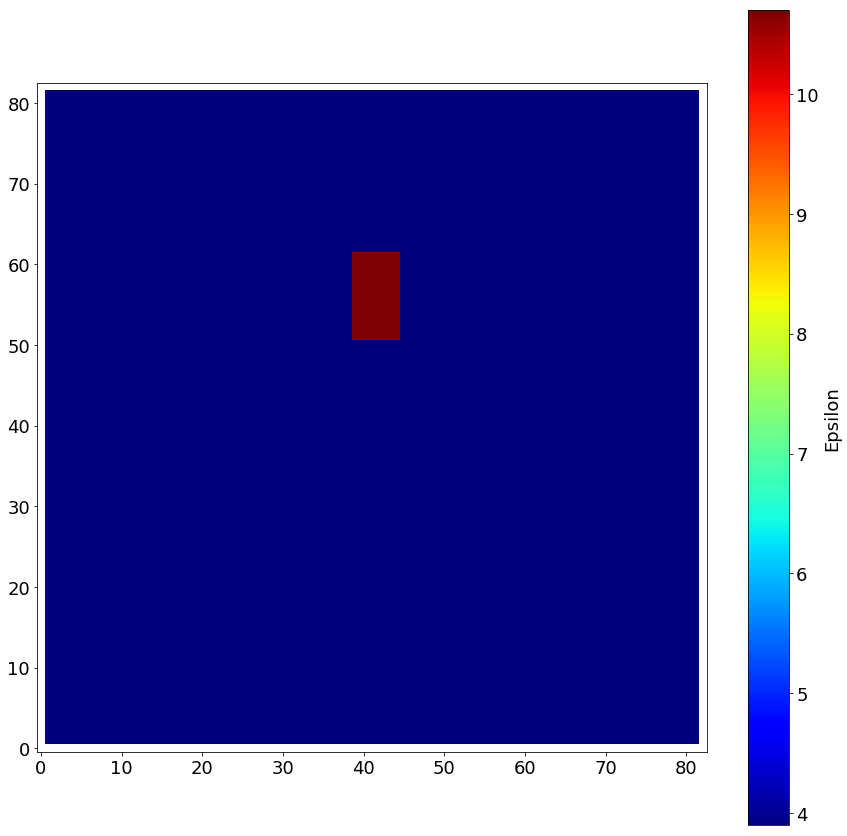

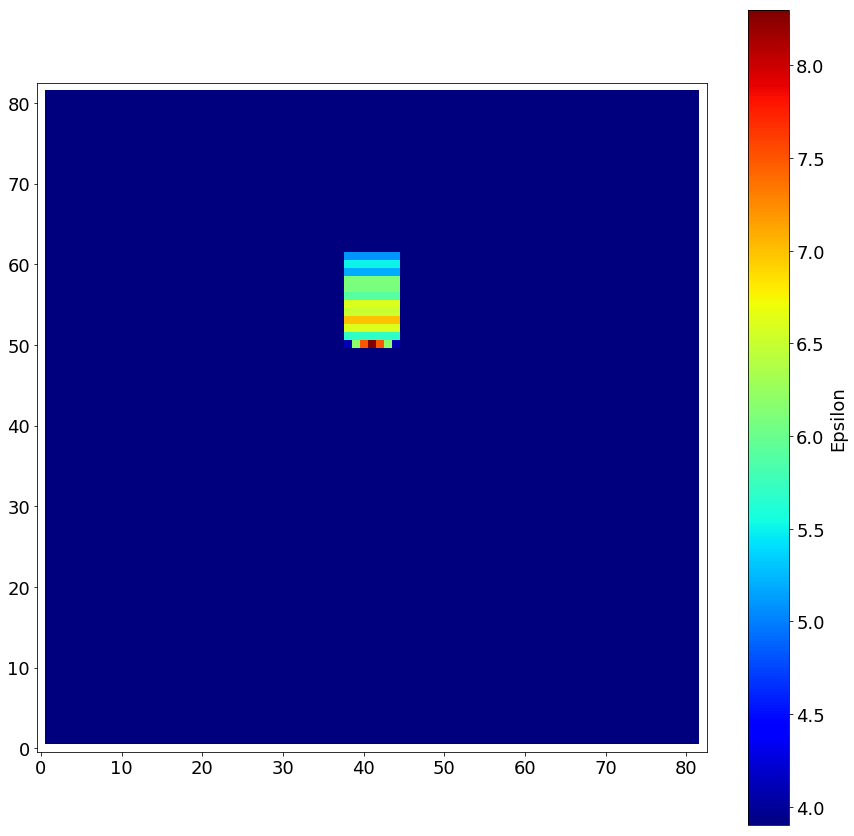

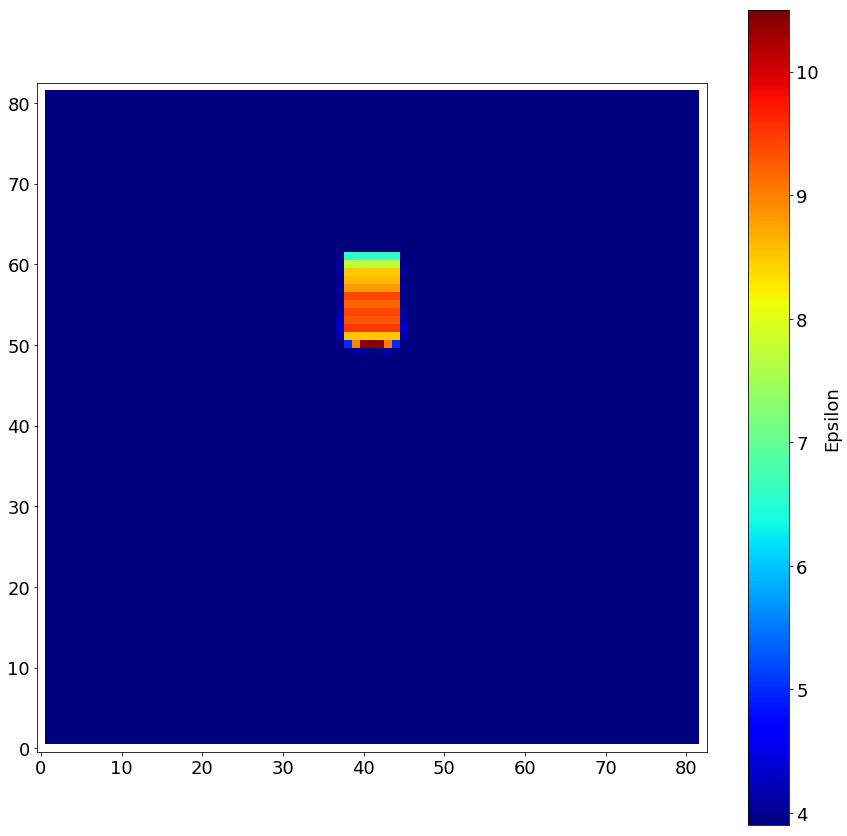

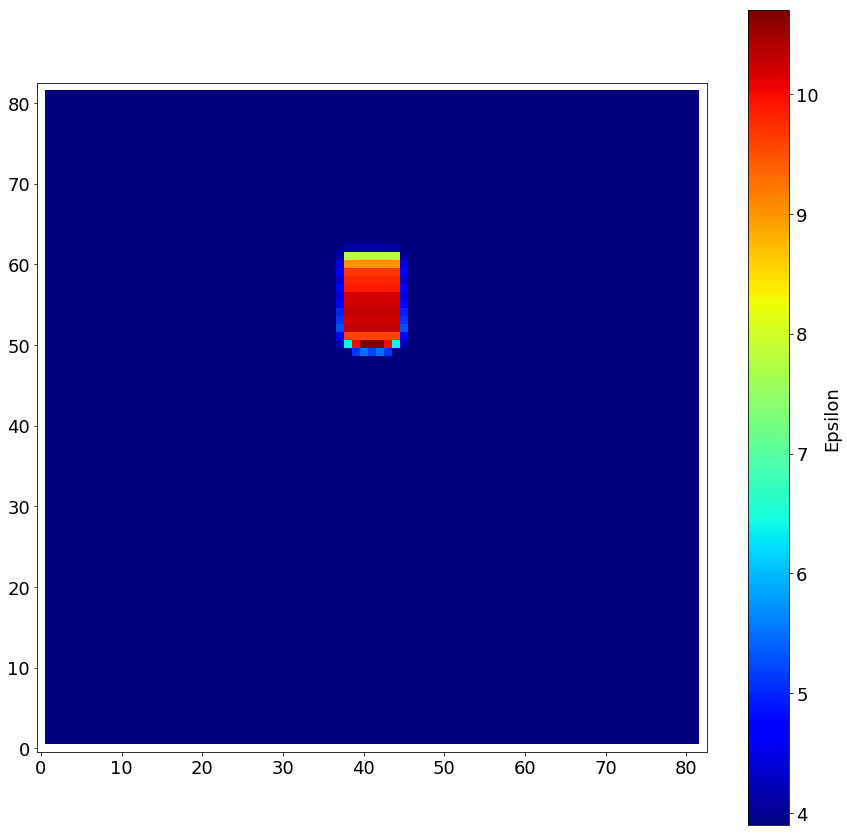

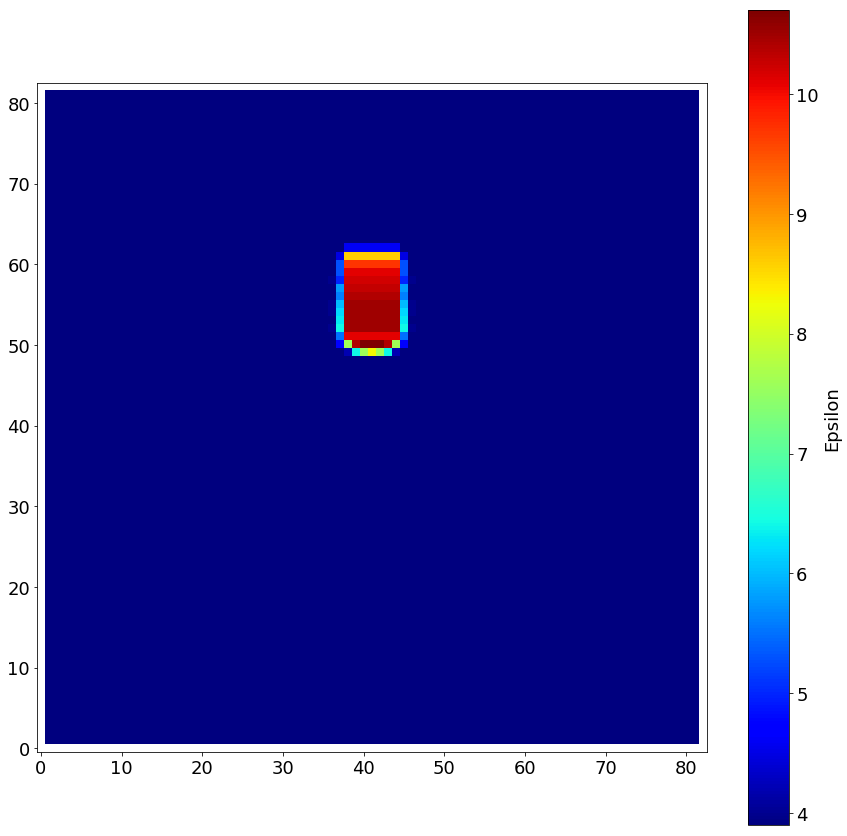

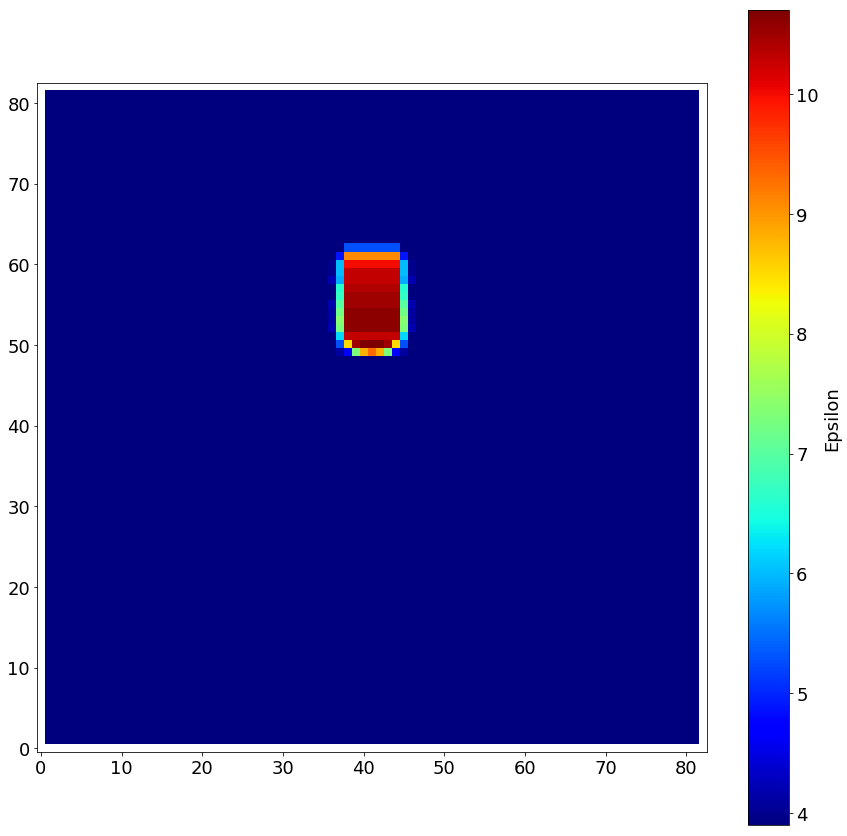

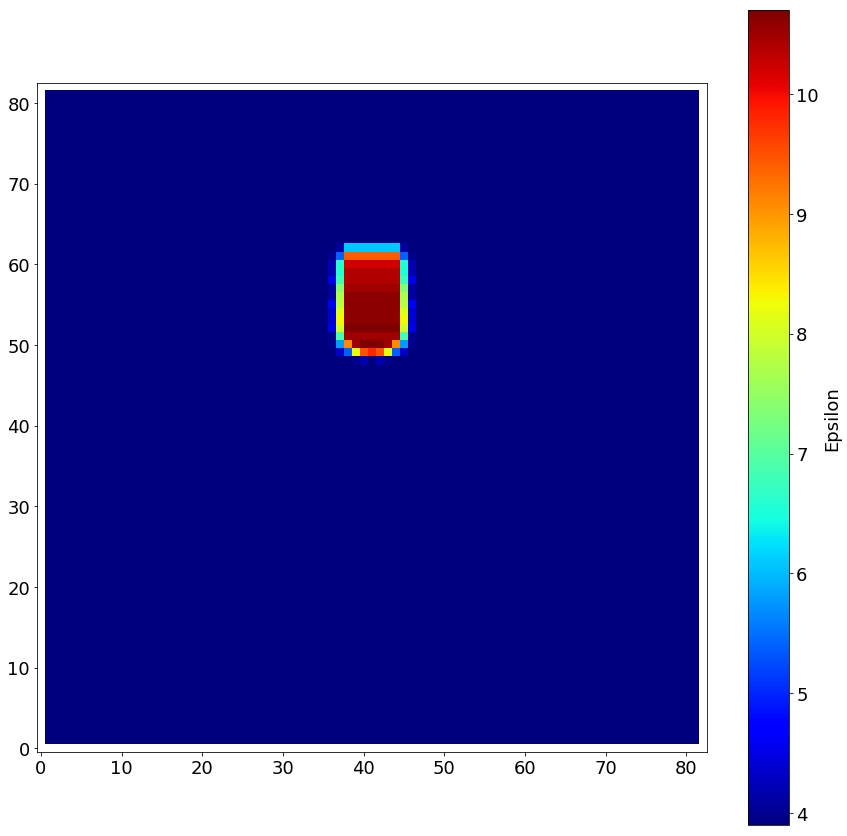

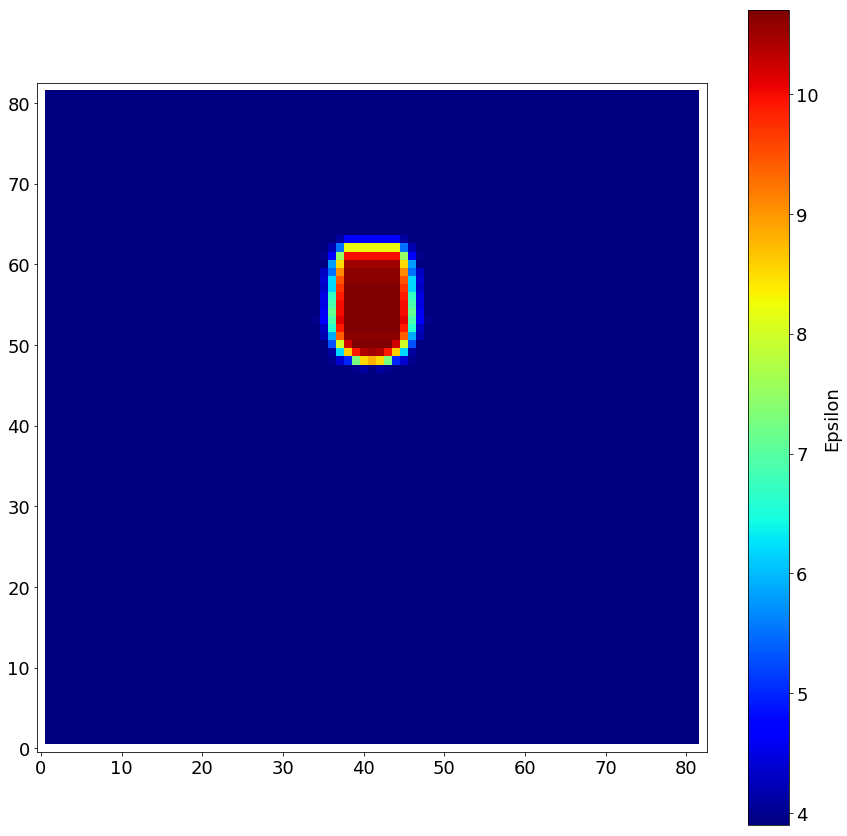

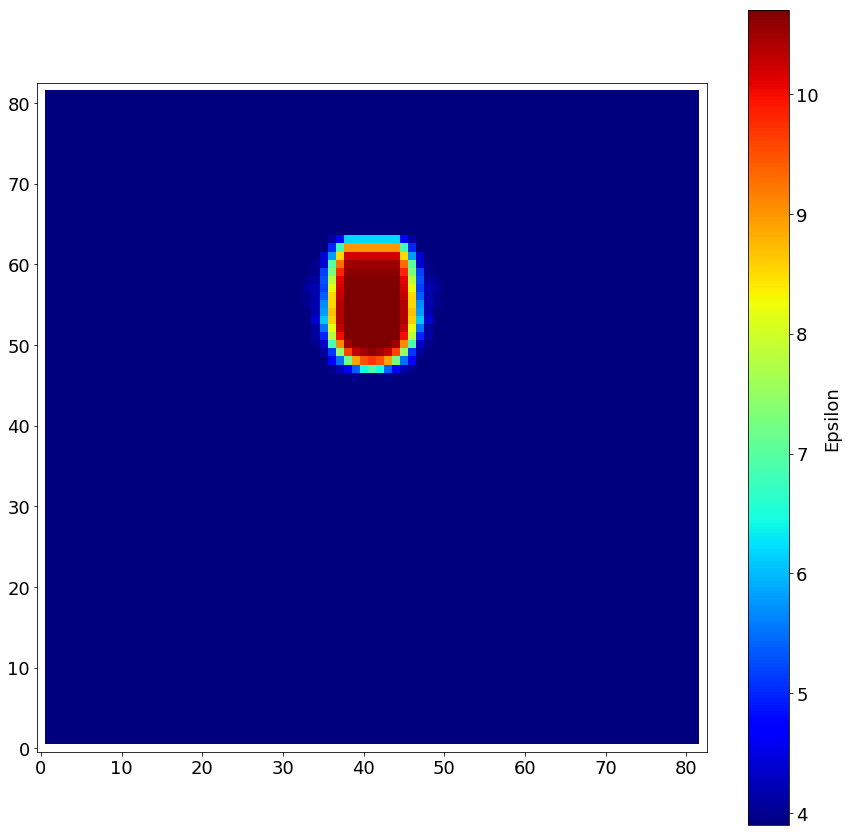

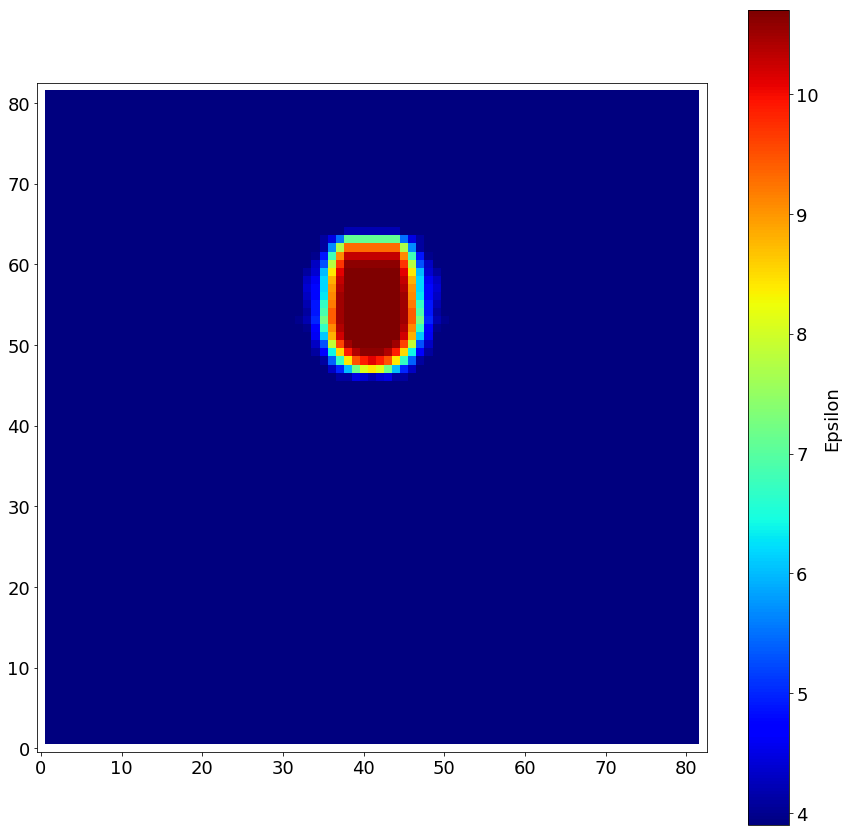

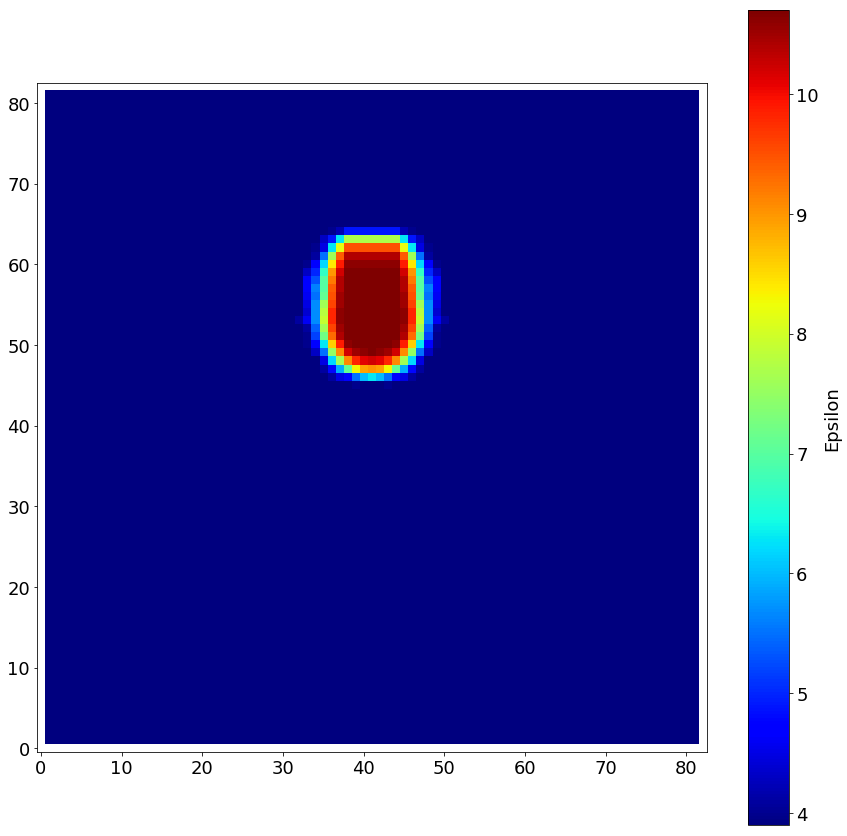

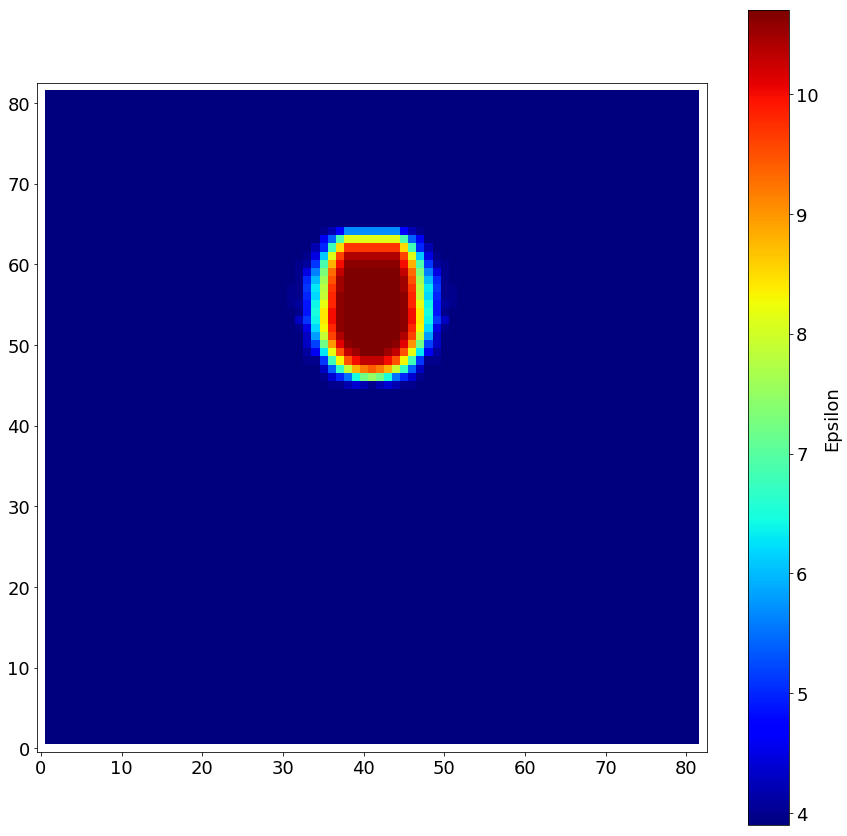

In [8]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colorbar as cb
from matplotlib import cm

#plt.scatter(A[:,0], A[:,1], s=300, c=A[:,2])
#plt.xticks((0,40,80),fontsize=50)
#plt.yticks((0,40,80), fontsize=50)
#xi,yi=np.meshgrid(A.round(3)[:,0], A.round(3)[:,1])
xi=np.arange(-0.01,0.82,0.01)
yi=xi
grid_x, grid_y = np.meshgrid(xi,yi)

for i in range(0,len(tps)):
    Agrid=griddata(A_tab[i][:,0:2], A_tab[i][:,2], (grid_x,grid_y))

    fig,ax=plt.subplots(figsize=(15,15))
    cax=ax.imshow(Agrid, origin='lower', interpolation='nearest',cmap=cm.jet)
    cbar=fig.colorbar(cax)
    cbar.set_label('Epsilon',fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()
#fig=ax.imshow(Agrid, origin='lower', cmap='jet')
#cbar=fig.colorbar()

In [ ]:
xi=np.arange(0,0.82,0.01)
yi=xi
grid_x, grid_y = np.meshgrid(xi,yi)

In [ ]:
yi=xi

In [ ]:
grid_x, grid_y = np.meshgrid(xi,yi)

In [5]:
A_tab

{0: array([[4.00000000e-01, 0.00000000e+00, 3.90000000e+00],
        [4.00000000e-01, 0.00000000e+00, 3.90000000e+00],
        [4.10000000e-01, 0.00000000e+00, 3.90000000e+00],
        ...,
        [1.00000000e-02, 8.00000000e-01, 3.90000000e+00],
        [8.00000000e-01, 8.00000000e-01, 3.90000000e+00],
        [4.33680869e-18, 8.00000000e-01, 3.90000000e+00]]),
 1: array([[4.00000000e-01, 0.00000000e+00, 3.90000000e+00],
        [4.00000000e-01, 0.00000000e+00, 3.90000000e+00],
        [4.10000000e-01, 0.00000000e+00, 3.90000000e+00],
        ...,
        [1.00000000e-02, 8.00000000e-01, 3.90000000e+00],
        [8.00000000e-01, 8.00000000e-01, 3.90000000e+00],
        [4.33680869e-18, 8.00000000e-01, 3.90000000e+00]]),
 2: array([[4.00000000e-01, 0.00000000e+00, 3.90000000e+00],
        [4.00000000e-01, 0.00000000e+00, 3.90000000e+00],
        [4.10000000e-01, 0.00000000e+00, 3.90000000e+00],
        ...,
        [1.00000000e-02, 8.00000000e-01, 3.90000000e+00],
        [8.00000000e

In [ ]:
grid_x.shape

In [ ]:
i=[0,3.9]

In [ ]:
materiaux[i[1]]

In [ ]:
A[o]

In [ ]:
ii=np.unique(A[o][:,1])
blou=A[o]
for i in ii:
    a=np.where(A[o,1]==i)
    b=np.where((A[:,0]==0.44) & (A[:,1]==i))
    for ii in a[1]:
        blou[ii,2]=A[b,2]
        A[o]=blou       

In [ ]:
a=np.where(A[:,1]==i)

In [ ]:
a=np.where(A[o][:,]

In [ ]:
a=np.where(A[o,1]==0.5)

In [ ]:
a=np.where((A[:,0]==0.44) & (A[:,1]==0.5))
print(a)

In [ ]:
type(i)

In [ ]:
a=np.where(A[:,1]==0.41)
print(a)

In [ ]:
A[o].shape

In [ ]:
materiaux